# Galaxy Classification Using Convolutional Neural Network

Our night sky is filled with billions of galaxies, each with billions of stars. With new technoly we are able to make telescopes that can probe even the farthest of the galaxies that were born just after the big bang. But analysing all the night sky is very difficult so we have to pick out targets wisely.
I propose a pipeline where the telescope data can be fed in and it will automatically classify the object based on their morphology or spectrum or anything that can be useful for the scientists. So here i have created the most crutial step of the pipeline, the classifier.

The original Galaxy10 dataset was created with Galaxy Zoo (GZ) Data Release 2 where volunteers classify ~270k of SDSS galaxy images where ~22k of those images were selected in 10 broad classes using volunteer votes. GZ later utilized images from DESI Legacy Imaging Surveys (DECals) with much better resolution and image quality. Galaxy10 DECals has combined all three (GZ DR2 with DECals images instead of SDSS images and DECals campaign ab, c) results in ~441k of unique galaxies covered by DECals where ~18k of those images were selected in 10 broad classes using volunteer votes with more rigorous filtering. Galaxy10 DECals had its 10 broad classes tweaked a bit so that each class is more distinct from each other and Edge-on Disk with Boxy Bulge class with only 17 images in original Galaxy10 was abandoned. The source code for this dataset is released under this repositary so you are welcome to play around if you like, otherwise you can use the compiled Galaxy10 DECals with dowload link below.

Galaxy10_DECals.h5: https://astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5

Galaxy10 DECals is a dataset contains 17736 256x256 pixels colored galaxy images (g, r and z band) separated in 10 classes. Galaxy10_DECals.h5 have columns images with shape (17736, 256, 256, 3), ans, ra, dec, redshift and pxscale in unit of arcsecond per pixel

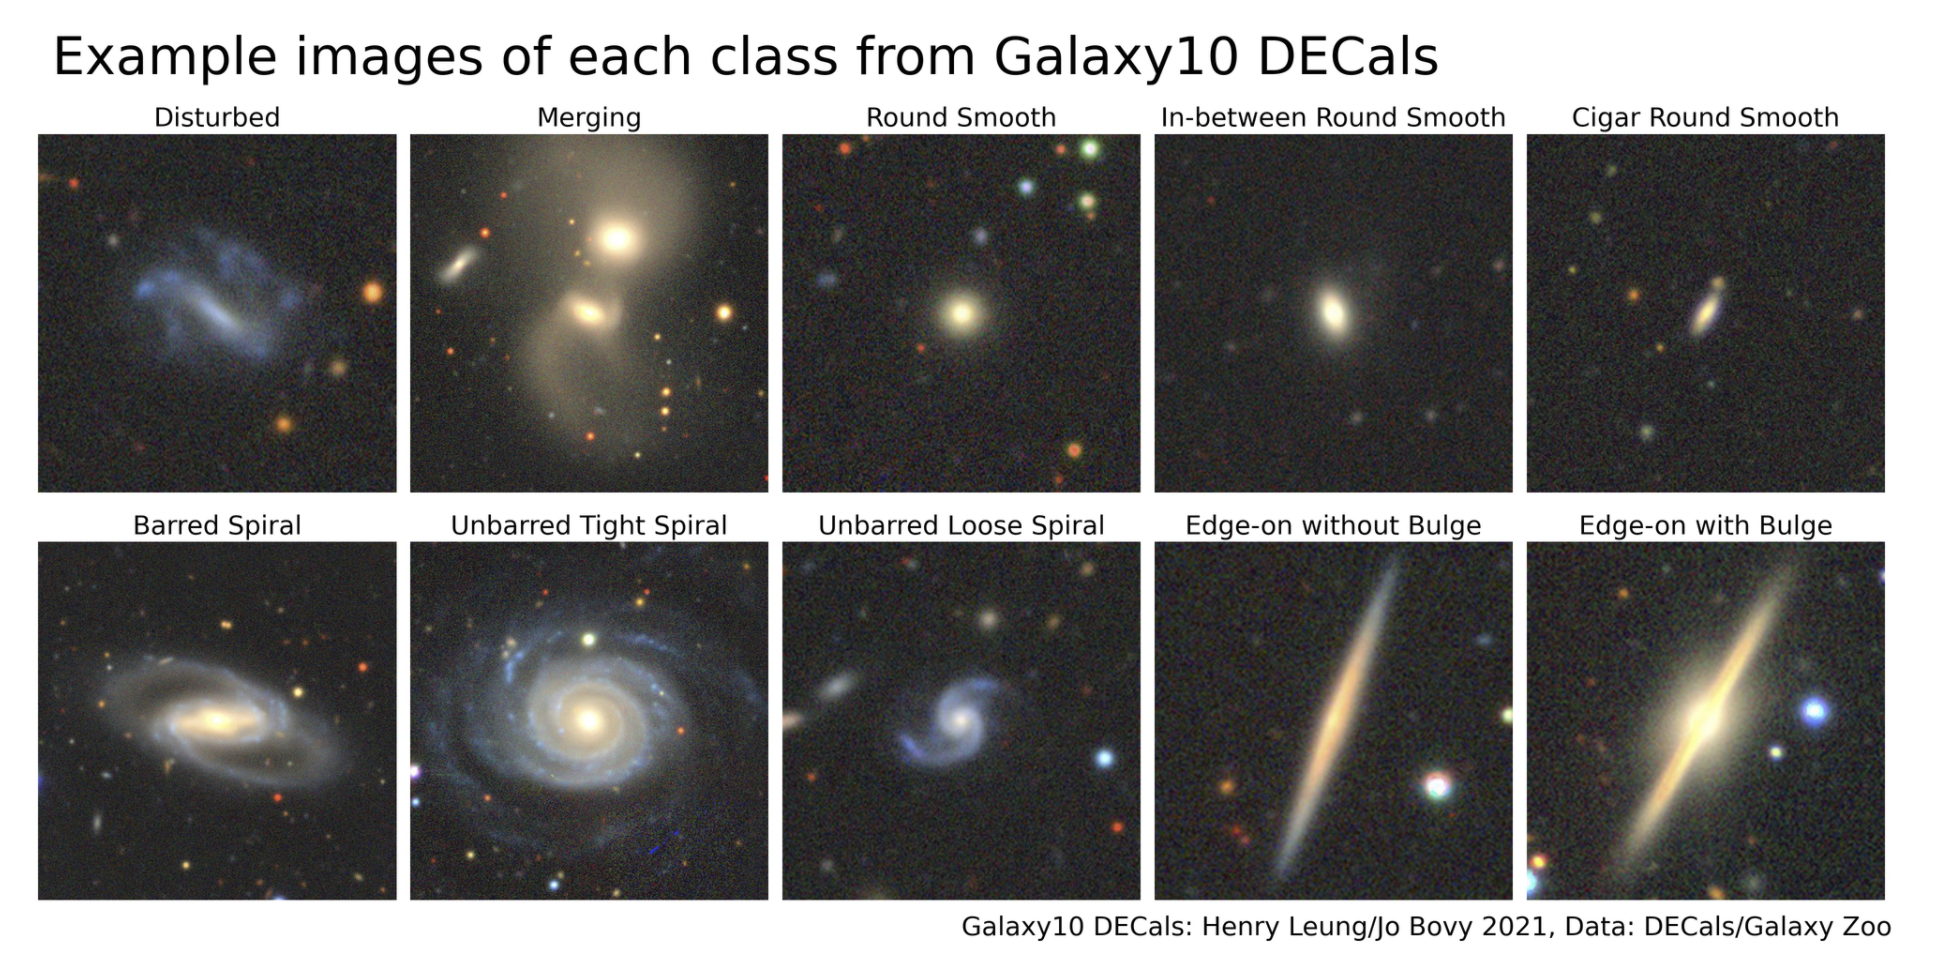

## Importing required library

In [2]:
!pip install h5py

In [4]:
import h5py
import numpy as np
from tensorflow.keras import utils 

## Collecting the Image data
The data is stored in .h5 file format. So here I am using h5py library to open the image data and storing it in a numpy array.

In [41]:
with h5py.File('../Data/Galaxy10_DECals.h5','r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

In [6]:
import PIL
import matplotlib.pyplot as plt
import random

### Labels 

In [7]:
label_names = ['Disturbed Galaxy',
               'Merging Galaxy',
               'Round Smooth Galaxy',
               'In-between Round Smooth Galaxy',
               'Cigar Shaped Smooth Galaxy',
               'Barred Spiral Galaxy',
               'Unbarred Tight Spiral Galaxy',
               'Unbarred Loose Spiral Galaxy',
               'Edge-on Galaxy without Bulge',
               'Edge-on Galaxy with Bulge'
              ]

## Data Visualization

Here I have selected 16 images randomly from the dataset and they are displayed using `matplotlib.pyplot.imshow`.

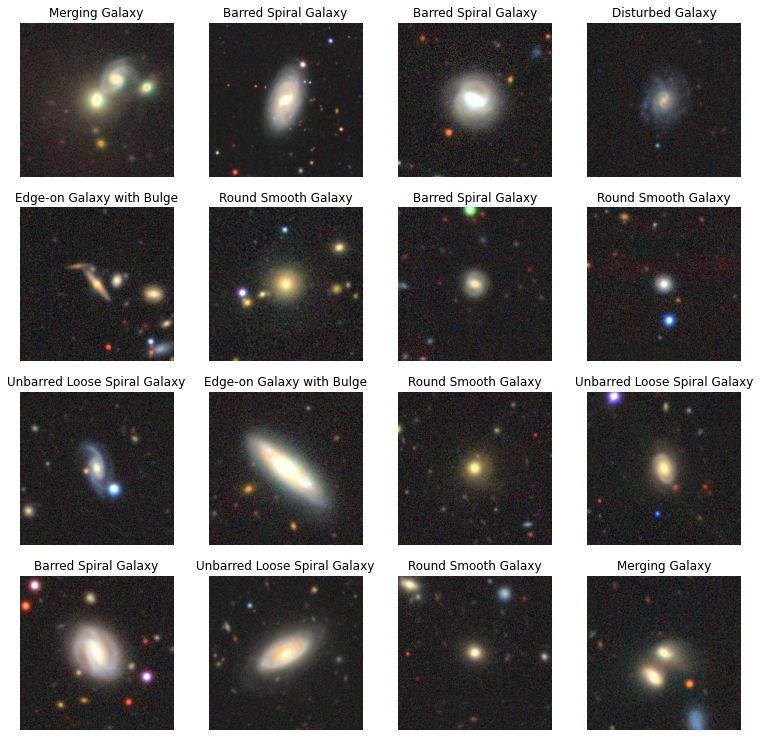

In [8]:
plt.figure(figsize=(13,13))
for i in range(16):
    index = random.randint(0,17736)
    image = images[index]
    plt.subplot(4,4,i + 1)
    plt.imshow(image)
    plt.title(label_names[labels[index]])
    plt.axis('off')

In [9]:
labels.shape

(17736,)

## Spliting the data Into Test and Traning set
Here I have used sci-kit learn library to split the numpy data into training and testing set. The ratio of training and testing set is  5:1. 

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size = 0.2)


In [12]:
train_images, train_labels, test_images, test_labels = images[train_idx], labels[train_idx], images[test_idx], labels[test_idx]

In [13]:
print(train_images.shape[0], test_images.shape[0])

14188 3548


In [14]:
images.shape

(17736, 256, 256, 3)

## Preparing the dataset


In [42]:
import tensorflow as tf

img_height = 256
img_width = 256

In [18]:
class_names = label_names

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [20]:
BATCH_SIZE = 50
SHUFFLE_BUFFER_SIZE = 1000

In [21]:
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [22]:
EPOCHS = 5

# Standardise the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general we should seek to make your input values small.

Here, I have standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
from tensorflow.keras import layers
normalization_layer = layers.Rescaling(1./255)

In [25]:
normalized_dataset = train_dataset.map(lambda x,y: (normalization_layer(x),y))
images_batch, labels_batch = next(iter(normalized_dataset))

In [26]:
num_classes = len(class_names)

## Creating the model
The Sequential model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy—the goal of this tutorial is to show a standard approach.

Below is an image to understand how neural network works, but instead of classifying animals we are classifying galaxies. 
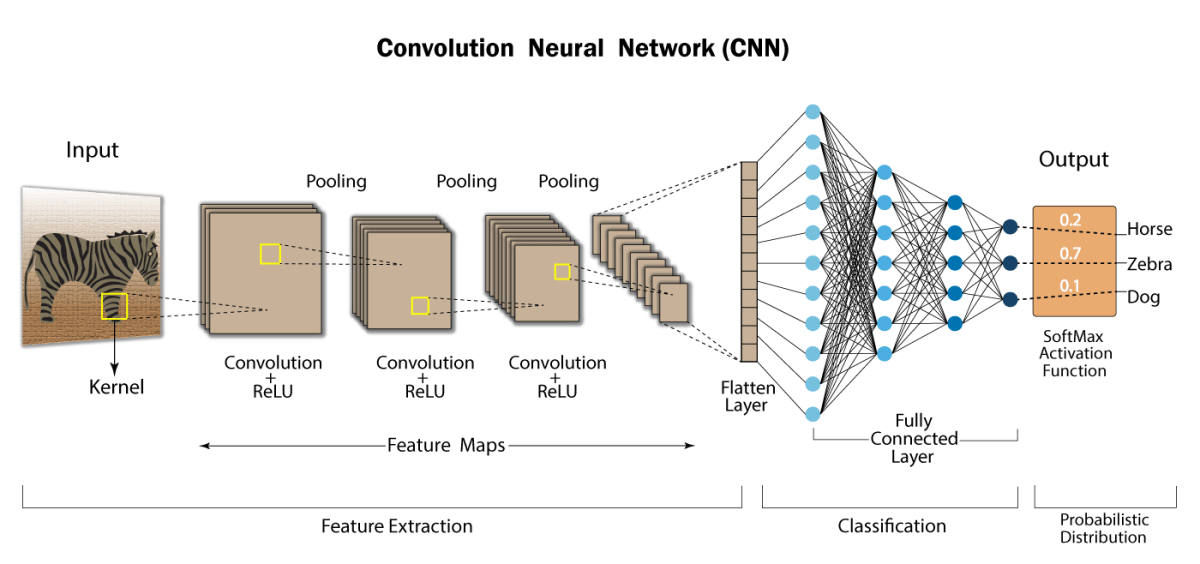

In [2]:
from tensorflow.keras.models import Sequential
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

NameError: name 'layers' is not defined

In [1]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

NameError: name 'model' is not defined

## Summary of the model
Here you can se all the hidden layers and their shapes, and total numbers of parameters after each layers is also shown.

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

# Training the model
I haved trained the model for 5 epochs to see how the model behaves.

In [27]:
EPOCHS = 5
history = model.fit(
    train_dataset, 
    validation_data = test_dataset,
    epochs = EPOCHS
)

Epoch 1/5
284/284 [==============================] - 20s 49ms/step - loss: 2.0042 - accuracy: 0.2447 - val_loss: 1.7909 - val_accuracy: 0.3174
Epoch 2/5
284/284 [==============================] - 13s 44ms/step - loss: 1.6224 - accuracy: 0.4007 - val_loss: 1.4915 - val_accuracy: 0.4501
Epoch 3/5
284/284 [==============================] - 13s 44ms/step - loss: 1.2760 - accuracy: 0.5389 - val_loss: 1.4778 - val_accuracy: 0.4749
Epoch 4/5
284/284 [==============================] - 13s 44ms/step - loss: 1.0344 - accuracy: 0.6324 - val_loss: 1.3889 - val_accuracy: 0.5172
Epoch 5/5
284/284 [==============================] - 13s 45ms/step - loss: 0.8017 - accuracy: 0.7198 - val_loss: 1.4810 - val_accuracy: 0.5285


# Visualising the training results

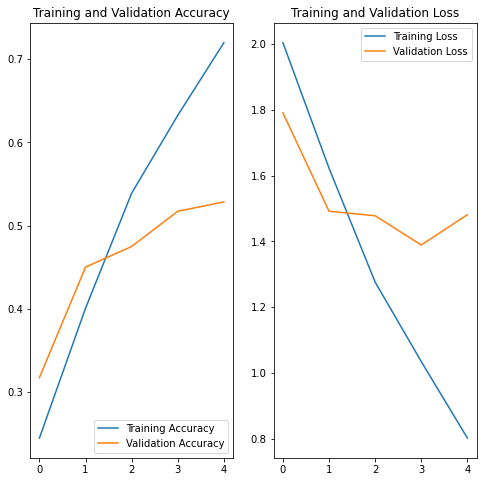

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Overfitting 

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. 
- Data Augmentation
- Dropout layer.

## Testing the results
 Here I have used a barred spiral galaxy image and the model is able to pridict it correctly, But not always. We need to improve the model.

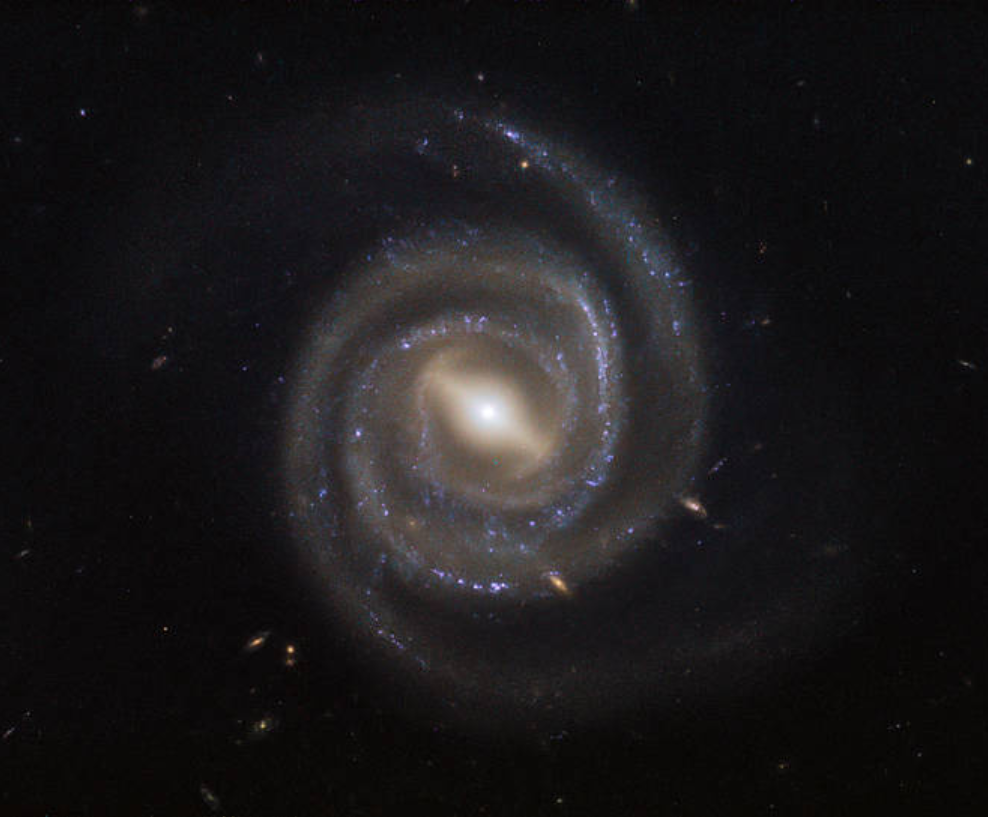

In [29]:
from tensorflow import keras
from tensorflow.keras import utils
barred_spiral_img = tf.keras.utils.load_img('../Data/new_test_data/barred_spiral_test1.png', target_size = (img_height, img_width))
PIL.Image.open('../Data/new_test_data/barred_spiral_test1.png')

In [30]:
img_array = tf.keras.utils.img_to_array(barred_spiral_img)
img_array = tf.expand_dims(img_array, 0)



In [31]:
prediction = model.predict(img_array)

In [32]:
score = tf.nn.softmax(prediction[0])

In [33]:
for i in score: print(i)

tf.Tensor(0.07197627, shape=(), dtype=float32)
tf.Tensor(0.059918653, shape=(), dtype=float32)
tf.Tensor(0.0040735723, shape=(), dtype=float32)
tf.Tensor(0.0020373825, shape=(), dtype=float32)
tf.Tensor(4.951063e-06, shape=(), dtype=float32)
tf.Tensor(0.77023846, shape=(), dtype=float32)
tf.Tensor(0.0071348613, shape=(), dtype=float32)
tf.Tensor(0.08411451, shape=(), dtype=float32)
tf.Tensor(8.2698214e-05, shape=(), dtype=float32)
tf.Tensor(0.00041850048, shape=(), dtype=float32)


In [34]:
print('This galaxy is most likely to be a ' + str(class_names[np.argmax(score)]) + '.')

This galaxy is most likely to be a Barred Spiral Galaxy.


# Data Augmentation
Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

I will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, `tf.keras.layers.RandomTranslation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [29]:
zoom_factor = (-0.1,0.5)
data_augmentation = Sequential([
    layers.RandomFlip('horizontal_and_vertical',input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.5),
    #layers.RandomZoom(height_factor=zoom_factor, width_factor=zoom_factor),
    layers.RandomZoom((-0.5,0.1),fill_mode='wrap'),
    layers.RandomTranslation(0.08,0.08)#, fill_mode='wrap')
])

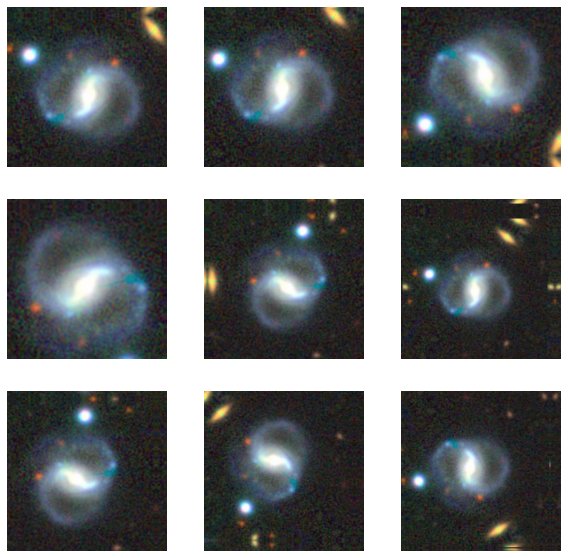

In [40]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Dropout

In [37]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [38]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [39]:
EPOCHS = 100

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [41]:
history = model.fit(train_dataset,
                   validation_data= test_dataset,
                   epochs=EPOCHS) 

Epoch 1/100
284/284 [==============================] - 19s 60ms/step - loss: 1.9943 - accuracy: 0.2505 - val_loss: 1.8324 - val_accuracy: 0.3126
Epoch 2/100
284/284 [==============================] - 16s 57ms/step - loss: 1.6606 - accuracy: 0.3771 - val_loss: 1.4974 - val_accuracy: 0.4462
Epoch 3/100
284/284 [==============================] - 16s 58ms/step - loss: 1.4607 - accuracy: 0.4538 - val_loss: 1.4886 - val_accuracy: 0.4346
Epoch 4/100
284/284 [==============================] - 16s 57ms/step - loss: 1.3698 - accuracy: 0.4922 - val_loss: 1.3908 - val_accuracy: 0.4963
Epoch 5/100
284/284 [==============================] - 16s 58ms/step - loss: 1.2978 - accuracy: 0.5245 - val_loss: 1.3375 - val_accuracy: 0.5025
Epoch 6/100
284/284 [==============================] - 16s 57ms/step - loss: 1.2314 - accuracy: 0.5522 - val_loss: 1.1787 - val_accuracy: 0.5753
Epoch 7/100
284/284 [==============================] - 17s 59ms/step - loss: 1.1405 - accuracy: 0.5870 - val_loss: 1.0567 - val_ac

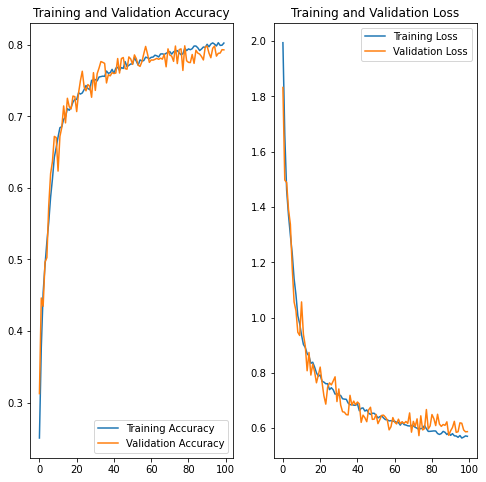

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
prediction = model.predict(img_array)

In [44]:
score = tf.nn.softmax(prediction[0])
for i in score: print(i)

tf.Tensor(0.031662643, shape=(), dtype=float32)
tf.Tensor(1.3360906e-05, shape=(), dtype=float32)
tf.Tensor(1.7445062e-05, shape=(), dtype=float32)
tf.Tensor(9.918027e-09, shape=(), dtype=float32)
tf.Tensor(1.1274198e-11, shape=(), dtype=float32)
tf.Tensor(0.96132505, shape=(), dtype=float32)
tf.Tensor(6.0916893e-05, shape=(), dtype=float32)
tf.Tensor(0.006852181, shape=(), dtype=float32)
tf.Tensor(7.145125e-07, shape=(), dtype=float32)
tf.Tensor(6.769257e-05, shape=(), dtype=float32)


In [45]:
print('This galaxy is most likely to be a ' + str(class_names[np.argmax(score)]) + '.')

This galaxy is most likely to be a Barred Spiral Galaxy.


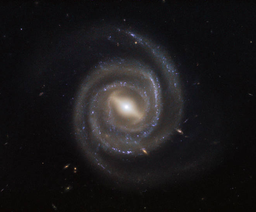

In [48]:
i = 5
test_img = tf.keras.utils.load_img(f'../Data/new_test_data/galaxy_test_{i}.png', target_size = (img_height, img_width))
disp_img = PIL.Image.open(f'../Data/new_test_data/galaxy_test_{i}.png')
#disp_img.resize((img_height, img_width))
size = (img_height, img_width)
disp_img.thumbnail(size, PIL.Image.ANTIALIAS)
disp_img

In [141]:
img_array = tf.keras.utils.img_to_array(test_img)
img_array = tf.expand_dims(img_array, 0)
img_array.shape

TensorShape([1, 256, 256, 3])

In [142]:
prediction = model.predict(img_array)

In [143]:
score = tf.nn.softmax(prediction[0])
for i in score: print(i)

tf.Tensor(0.029760612, shape=(), dtype=float32)
tf.Tensor(0.00096607377, shape=(), dtype=float32)
tf.Tensor(0.0001968926, shape=(), dtype=float32)
tf.Tensor(0.0004474812, shape=(), dtype=float32)
tf.Tensor(0.0014142577, shape=(), dtype=float32)
tf.Tensor(0.6551534, shape=(), dtype=float32)
tf.Tensor(0.010337954, shape=(), dtype=float32)
tf.Tensor(0.051949665, shape=(), dtype=float32)
tf.Tensor(0.10332805, shape=(), dtype=float32)
tf.Tensor(0.14644569, shape=(), dtype=float32)


In [144]:
print('This galaxy is most likely to be a ' + str(class_names[np.argmax(score)]) + '.')

This galaxy is most likely to be a Barred Spiral Galaxy.


In [107]:
class_names

['Disturbed Galaxy',
 'Merging Galaxy',
 'Round Smooth Galaxy',
 'In-between Round Smooth Galaxy',
 'Cigar Shaped Smooth Galaxy',
 'Barred Spiral Galaxy',
 'Unbarred Tight Spiral Galaxy',
 'Unbarred Loose Spiral Galaxy',
 'Edge-on Galaxy without Bulge',
 'Edge-on Galaxy with Bulge']